In [98]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

import sys
sys.path.insert(0,'..')

In [99]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


# 1. Load the data and get measurements

In [100]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 2

In [101]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [102]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [103]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (10, 2, 581)
GT S-parameters shape:  (10, 2, 581)
Y S-parameters shape:  (10, 2, 14)


In [104]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (581,)
Y frequencies shape:  (14,)


In [105]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  1000000000.0
Mean frequency spacing:  50000000.0
STD frequency spacing:  0.0
Mode frequency spacing:  50000000.0
Number of samples with non-equal spacing:  1


In [106]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [107]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  581
N_SPARAMS:  10


In [108]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 20, 581])


In [109]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 10, 581])


## Plot some stuff

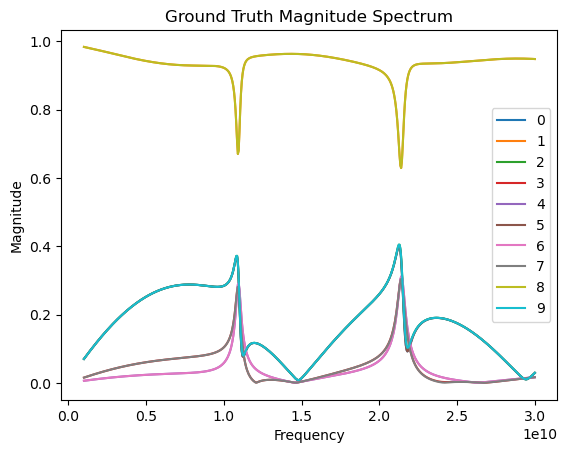

In [110]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

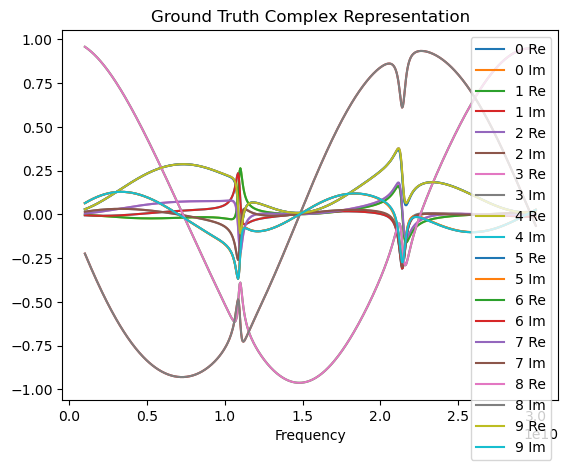

In [111]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [112]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 2

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)

Number of Ground Truth Frequency Points:  581
Number of Measurements:  2
Undersampling Ratio:  0.0034423407917383822
[  0 580]


In [113]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 20, 2])
y_freqs shape:  (2,)


# 2. Network Setup

## Define network parameters

In [114]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = False

In [115]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  20
NUM_LAYERS:  6
BASE NGF:  64
NGF:  [64, 64, 64, 64, 64, 64]
BS:  1
NC:  20
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [116]:
from models import RES_UNET

net = RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.0
               )
net = net.to(device)

In [117]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 20, 581])


In [118]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  349384


# 3. Run

## Define training parameters, losses, and track stats

In [119]:
#grab the correct file we want for VF
NUM_ACTIVE = 12

LR = 2e-4
NUM_ITER = 2000
TOTAL_ITERS = NUM_ITER * (NUM_ACTIVE + 1)
NUM_BURN_ITER = NUM_ITER * 0 # 0.2
SAMPLE_EVERY = 40

ACTIVE_ITER_RATIO = 0.1
SAMPLE_LAST_N = NUM_ITER * ACTIVE_ITER_RATIO

# TODO: maybe come back to this?
# TOTAL_ITER = NUM_ITER + 0.1 * NUM_ACTIVE * NUM_ITER

REG_HYPERPARAM = 1.0
NOISY_INPUT = True
USE_SGLD = False

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

def get_lr(optim):
    for g in optim.param_groups:
        return g['lr']
    
def set_lr(optim, lr):
    for g in optim.param_groups:
        g['lr'] = lr
        
START_NOISE_LEVEL = CUR_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS) 

START_LR = LR
END_LR = 1e-5
LR_DECAY_FACTOR = 1 # (END_LR / START_LR)**(1 / NUM_ITER)


train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

is_initial_fit = True
tic = time.time()
net.train()

# (NUM_ACTIVE + 1) * NUM_OUTPUTS * S_PARAMS * FREQS
sgld_outputs_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_means_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_stds_by_sample = []

for num_actively_sampled in range(NUM_ACTIVE + 1):

    cur_sgld_outputs = torch.Tensor().to(device)   

    if not is_initial_fit:

        # Find the maximum standard deviation point, and use it to update kept_inds
        max_disagree_idx = find_max_variance(sgld_outputs_by_sample[-1], pickRandom=True)
        kept_inds = np.sort(np.append(kept_inds, max_disagree_idx))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]

        # Update the LR and noise level based on our decay rates
        set_lr(optim, START_LR * LR_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) * NUM_ITER / ACTIVE_ITER_RATIO))
        # CUR_NOISE_LEVEL = START_NOISE_LEVEL * NOISE_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) *  NUM_ITER / ACTIVE_ITER_RATIO)

    # Update the criterion to reflect the new point we have sampled
    criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
    criterion = criterion.to(device)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=LR_DECAY_FACTOR)


    for i in range(int(NUM_ITER)):
        optim.zero_grad()
        
        if NOISY_INPUT:
            out = net.forward_with_z(CUR_NOISE_LEVEL)
            CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
        else:
            out = net.forward_with_z()
        
        train_error = criterion(out, y) 
        if REG_HYPERPARAM > 0:
            train_reg = REG_HYPERPARAM * regularizer(out)
            train_loss = train_error + train_reg
        else:
            train_loss = train_error
        
        train_loss.backward()
        optim.step()
        scheduler.step()

        with torch.no_grad():
            # First 20% of training will be burn-in iterations
            if (not is_initial_fit or i > NUM_BURN_ITER) and USE_SGLD:
                # Perform SGLD by adding Gaussian noise to parameters after gradient descent
                for param in net.parameters():
                    # param.add_(torch.normal(0, get_lr(optim), size=param.size()).to(device))
                    param.add_(torch.randn_like(param) * get_lr(optim) * 2)
            
            # Log the standard metrics across different numbers of samples given
            train_losses.append(train_loss.item())
            train_errors.append(train_error.item())
            if REG_HYPERPARAM > 0:
                train_regs.append(train_reg.item())
            
            test_mse = nn.MSELoss()(out, x)
            test_mses.append(test_mse.item())
            
            test_mae = nn.L1Loss()(out, x)
            test_maes.append(test_mae.item())

            if (i+1)%1000 == 0 or i == 0:
                toc = time.time()
                print("ITER ", str(i))
                print("TIME: ", str(toc - tic))
                if NOISY_INPUT:
                    print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
                print()

            # Get SGLD outputs for finding mean/std
            if (NUM_ITER - i <= SAMPLE_LAST_N) and i % SAMPLE_EVERY == 0:
                cur_sgld_outputs = torch.cat([cur_sgld_outputs, out])

    sgld_outputs_by_sample.append(cur_sgld_outputs)
    sgld_means_by_sample.append(torch.mean(cur_sgld_outputs, dim=0))
    sgld_stds_by_sample.append(torch.std(cur_sgld_outputs, dim=0))

    if is_initial_fit :
    #     NUM_ITER *= ACTIVE_ITER_RATIO
        is_initial_fit = False


    def find_max_variance(outputs, pickRandom=False):
        # Outputs of shape [NUM_OUTPUTS, 20, 1000]

        # Call np.var with dim = 0 to get shape [20, 1000]
        var_output = torch.var(outputs, dim=0)

        # Sum to go to [1000]
        var_output = torch.sum(var_output, dim=0)

        if pickRandom:
            while True:
                rand_idx = random.randint(0, len(var_output) - 1)
                if rand_idx not in kept_inds:
                    print("picked: ", rand_idx)
                    return rand_idx

        _, idxs = torch.topk(var_output, len(var_output))

        for idx in idxs:
            if idx.item() not in kept_inds:
                return idx.item()
        return -1
    
    print("NUM_SAMPLES ", str(num_actively_sampled))
    print("TIME: ", str(toc - tic))


ITER  0
TIME:  0.03912854194641113
NOISE LEVEL:  0.9997343523952296

ITER  999
TIME:  33.50095009803772
NOISE LEVEL:  0.7666822074546439

ITER  1999
TIME:  66.7592670917511
NOISE LEVEL:  0.5878016072275256

NUM_SAMPLES  0
TIME:  66.7592670917511
picked:  520
[  0 520 580]
ITER  0
TIME:  66.79522395133972
NOISE LEVEL:  0.5876454591384854

ITER  999
TIME:  96.21736788749695
NOISE LEVEL:  0.45065703377458677

ITER  1999
TIME:  127.04013681411743
NOISE LEVEL:  0.3455107294592608

NUM_SAMPLES  1
TIME:  127.04013681411743
picked:  399
[  0 399 520 580]
ITER  0
TIME:  127.07568907737732
NOISE LEVEL:  0.3454189453615575

ITER  999
TIME:  160.47339487075806
NOISE LEVEL:  0.2648969287610904

ITER  1999
TIME:  192.8780767917633
NOISE LEVEL:  0.20309176209050778

NUM_SAMPLES  2
TIME:  192.8780767917633
picked:  490
[  0 399 490 520 580]
ITER  0
TIME:  192.91338443756104
NOISE LEVEL:  0.20303781125035983

ITER  999
TIME:  225.7915279865265
NOISE LEVEL:  0.15570684047540365

ITER  1999
TIME:  258.58

In [120]:
# NUM_FORWARD_PASSES = 100
# sums_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# sums_squared_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# for i in range(NUM_FORWARD_PASSES):
#     sums_forward_pass_outputs += net.forward_with_z().cpu()
#     sums_squared_forward_pass_outputs += torch.square(net.forward_with_z()).cpu()

# mean_forward_pass_outputs = sums_forward_pass_outputs / NUM_FORWARD_PASSES
# std_forward_pass_outputs = torch.sqrt(((NUM_FORWARD_PASSES * sums_squared_forward_pass_outputs) - (sums_forward_pass_outputs * sums_forward_pass_outputs)) / (NUM_FORWARD_PASSES * (NUM_FORWARD_PASSES - 1)))

print(sgld_outputs_by_sample[0].shape)
print(sgld_means_by_sample[0].shape)
print(sgld_stds_by_sample[0].shape)

torch.Size([5, 20, 581])
torch.Size([20, 581])
torch.Size([20, 581])


## Plot metrics and outputs

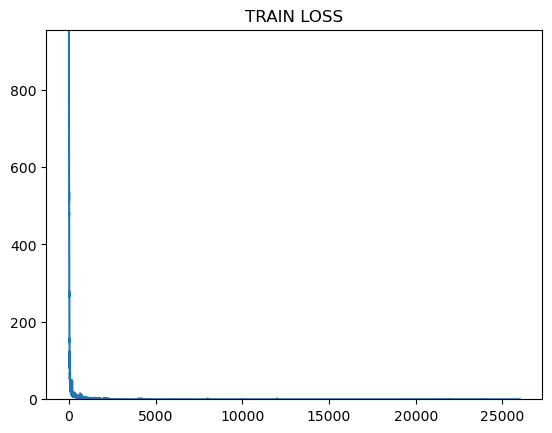

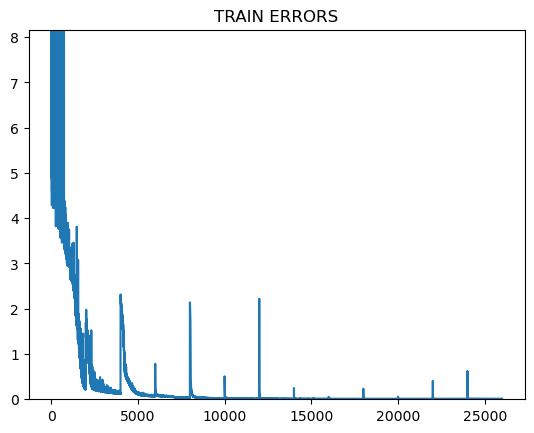

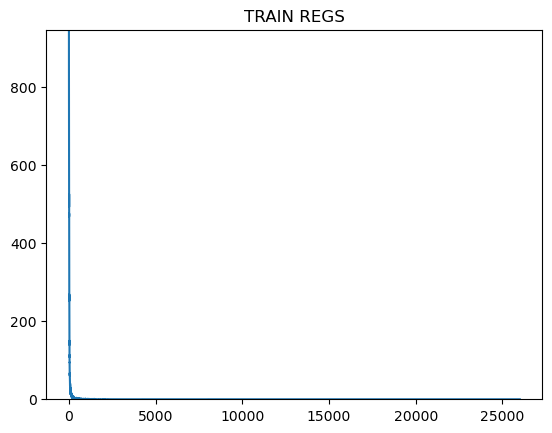

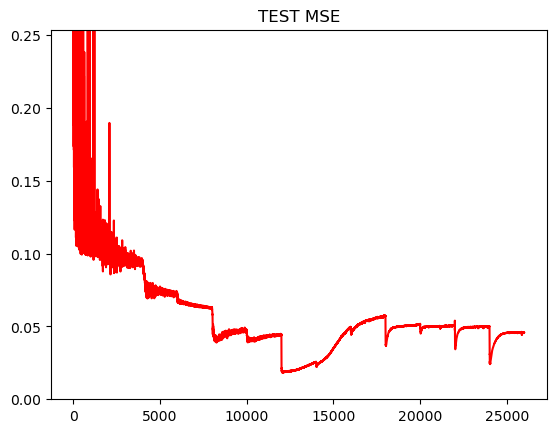

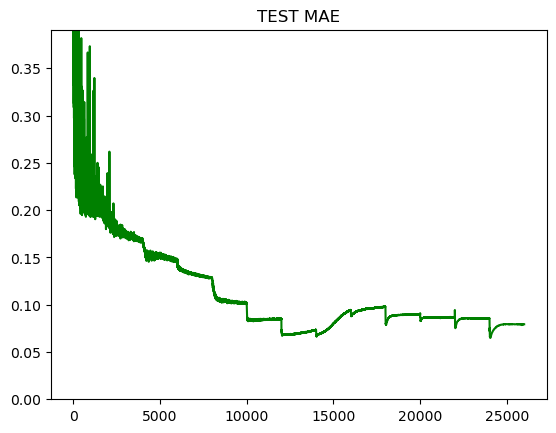

In [121]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [122]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.04592321068048477
Best Test MSE:  0.01818687468767166
Best Test MSE Iteration:  12075


In [123]:
# Make the VF Solution and use it as input to network
import VF.vectorfit
import os

LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case02/case02.s4p
[1.000e+09 6.500e+09 9.600e+09 1.015e+10 1.255e+10 1.415e+10 1.495e+10
 1.705e+10 1.765e+10 2.095e+10 2.550e+10 2.700e+10 2.795e+10 3.000e+10]
Performing fit with 1 poles.
  Fitting took 0.038129888474941254 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.012093592435121536 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 3 poles better than 2 (err 0.010101823191969653 vs 0.050739837793847026)
Performing fit with 3 poles.
  Fitting took 0.3234144560992718 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 3 (err 0.0016559441370209132 vs 0.010101823191969653)
Performing fit with 4 poles.
  Fitting took 0.14579464308917522 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better t

In [124]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

print("Final DIP MSE: ", test_mses[-1])
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())
print("Mean DIP MSE: ", nn.MSELoss()(sgld_means_by_sample[-1][np.newaxis], x).item())

torch.Size([581, 4, 4, 2])
torch.Size([581, 4, 4, 2])
torch.Size([14, 4, 4, 2])
(581, 4, 4, 2)
(581, 4, 4, 2)
(10, 2, 581)
(10, 2, 581)
float32
float32
DIP PSNR:       19.400277826598426
VF PSNR:        38.781115776069115
Final DIP MSE:  0.04592321068048477
VF MSE:         0.000529600540176034
Mean DIP MSE:  0.04557856544852257


(581,)
torch.Size([20, 581])
torch.Size([1, 20, 581])
torch.Size([1, 20, 14])
torch.Size([1, 20, 581])
torch.Size([1, 20, 581])


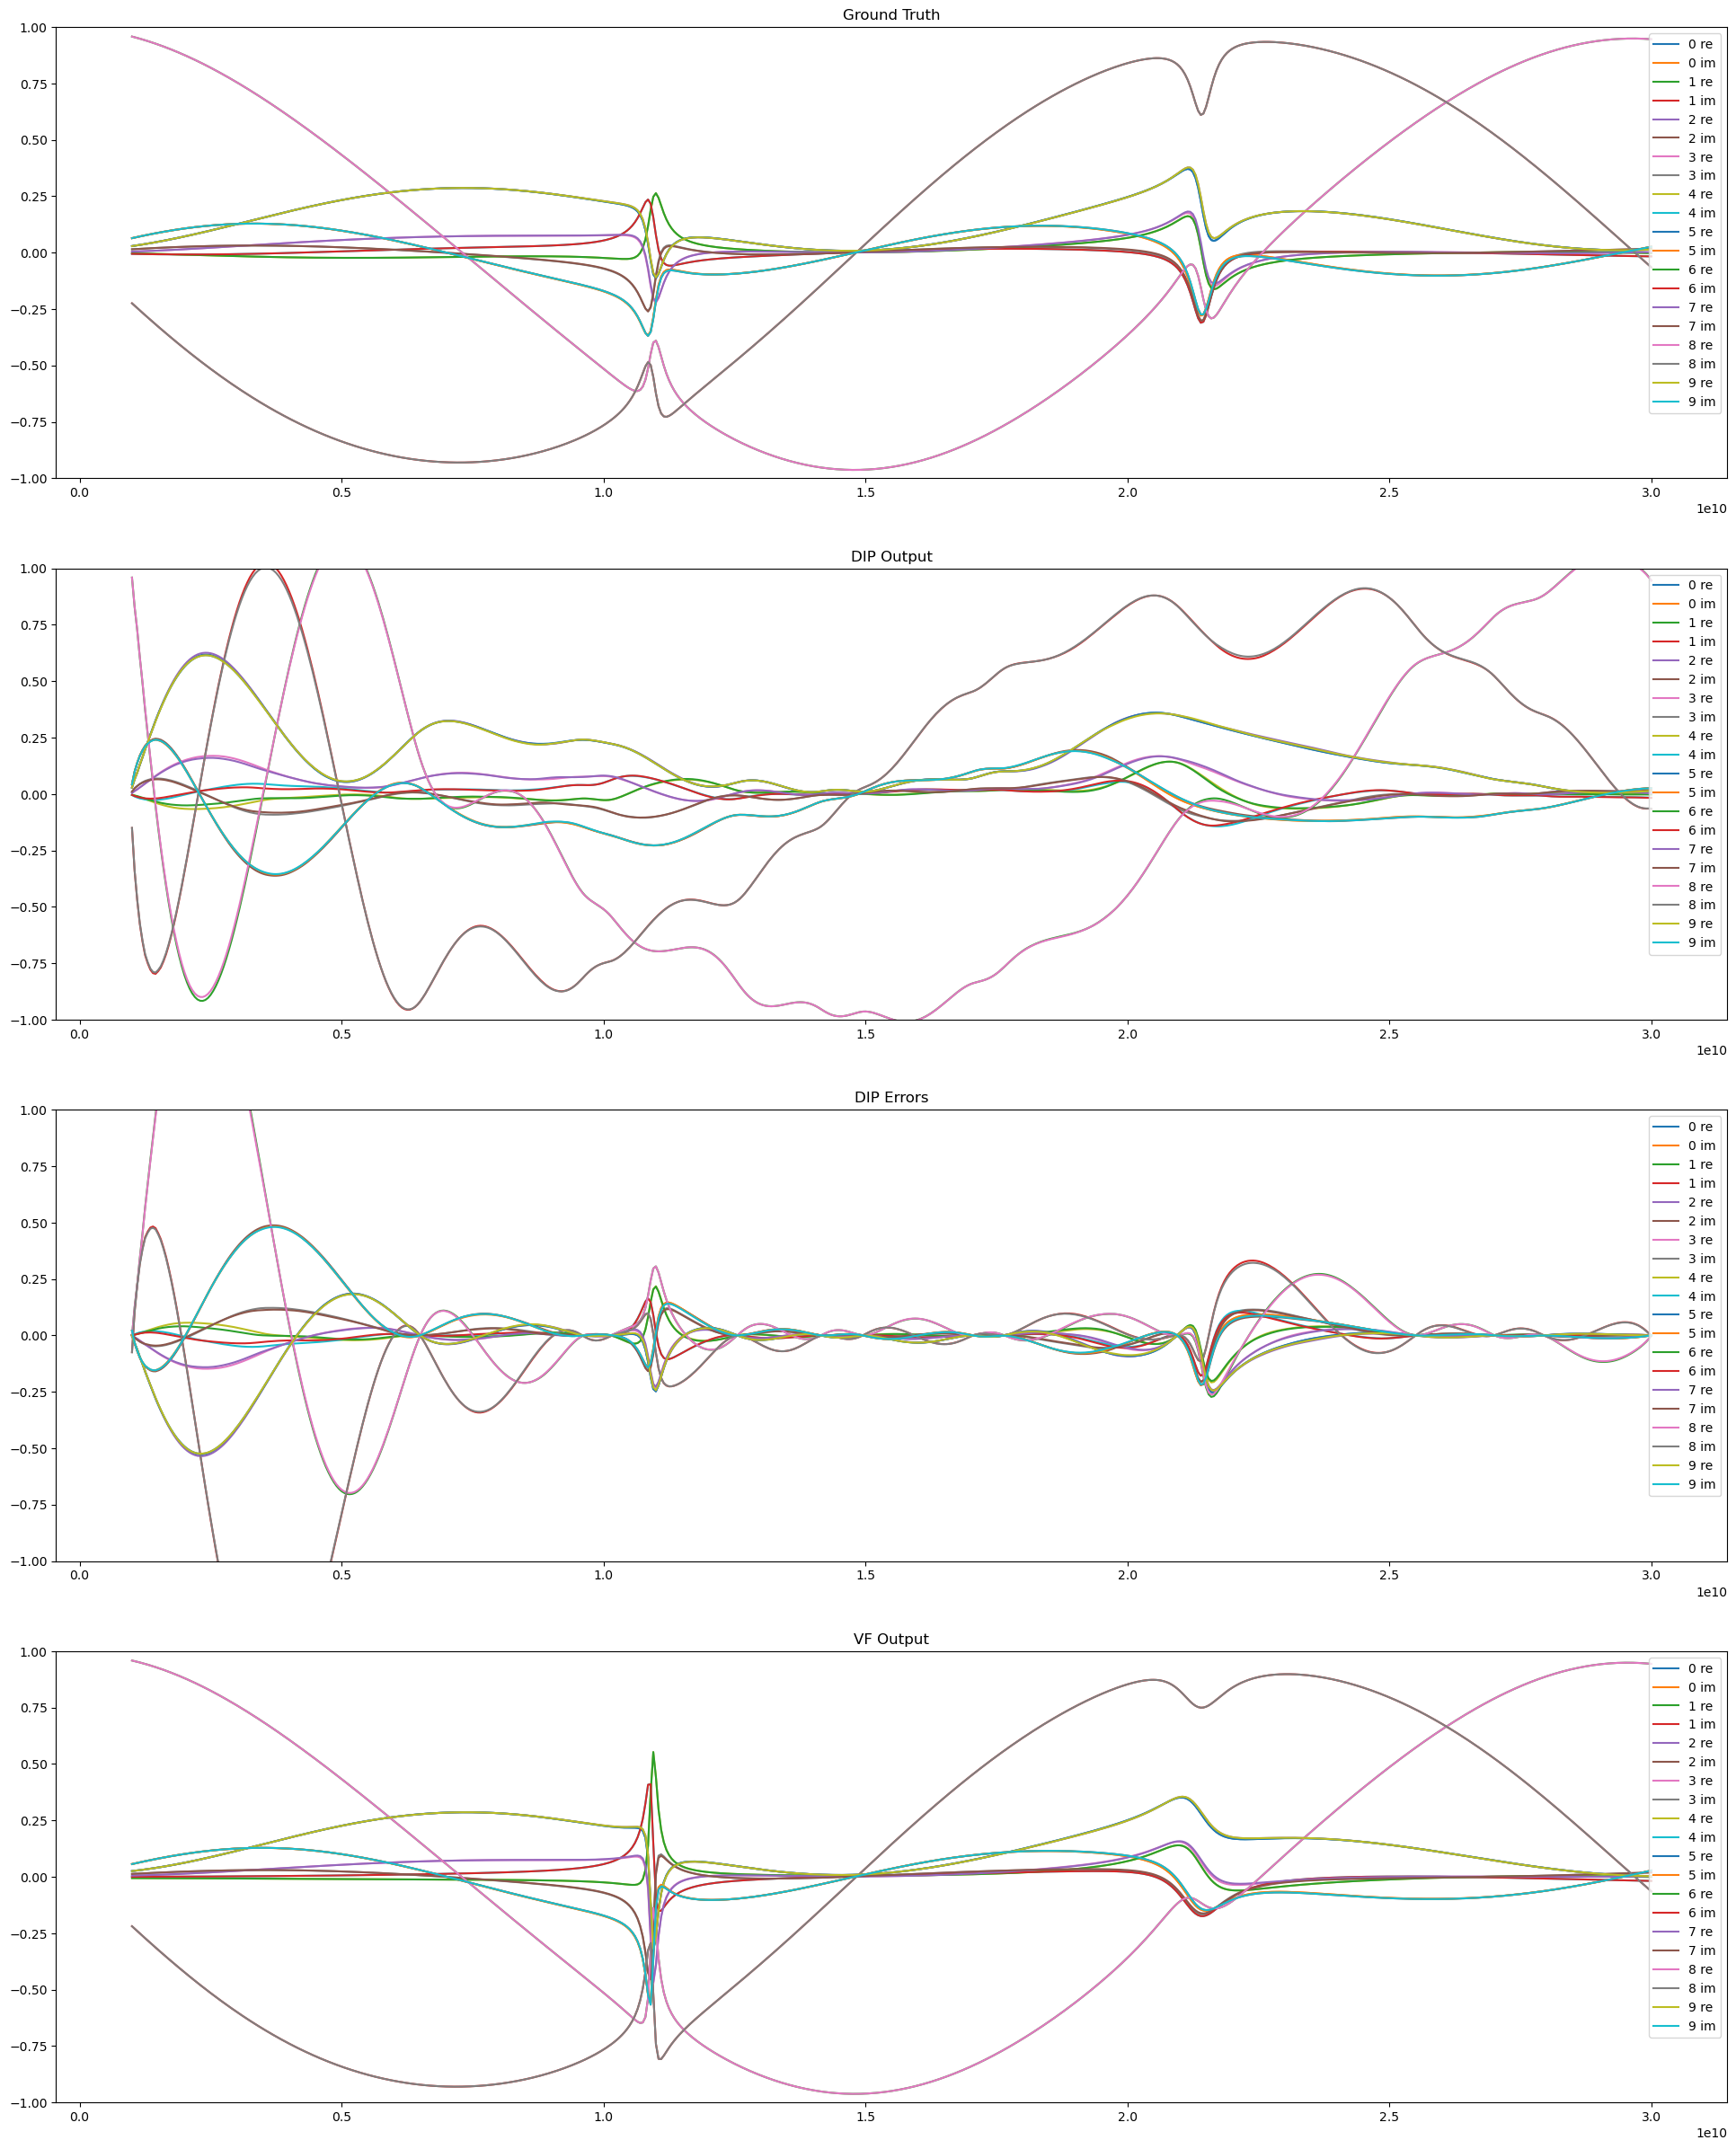

In [125]:
dip_errors = x.detach().cpu() - sgld_means_by_sample[-1].detach().cpu()
print(gt_freqs.shape)
print(sgld_means_by_sample[-1].shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

In [126]:
torch.set_printoptions(threshold=100000)
print(sgld_stds_by_sample[-1])

tensor([[1.8728e-04, 2.2651e-04, 2.6556e-04, 2.5750e-04, 2.5613e-04, 2.6891e-04,
         3.1273e-04, 3.4374e-04, 3.6218e-04, 3.8178e-04, 4.0554e-04, 4.2759e-04,
         4.5311e-04, 4.9723e-04, 5.5924e-04, 6.2818e-04, 6.9981e-04, 7.6639e-04,
         8.2576e-04, 8.7944e-04, 9.2679e-04, 9.6638e-04, 9.9770e-04, 1.0176e-03,
         1.0259e-03, 1.0176e-03, 9.9286e-04, 9.5093e-04, 8.9351e-04, 8.3534e-04,
         7.8119e-04, 7.4077e-04, 7.2173e-04, 7.2337e-04, 7.4058e-04, 7.6297e-04,
         7.8579e-04, 8.0276e-04, 8.1068e-04, 8.2544e-04, 8.4736e-04, 8.8148e-04,
         9.2751e-04, 9.6026e-04, 9.7788e-04, 9.7940e-04, 9.6495e-04, 9.3751e-04,
         8.9742e-04, 8.2332e-04, 7.5363e-04, 6.8591e-04, 6.2059e-04, 5.6795e-04,
         5.0739e-04, 4.5968e-04, 4.2311e-04, 4.0000e-04, 3.9194e-04, 3.9539e-04,
         4.1327e-04, 4.4237e-04, 4.7866e-04, 5.0988e-04, 5.3349e-04, 5.6114e-04,
         5.9193e-04, 6.1076e-04, 6.1682e-04, 6.0579e-04, 5.7821e-04, 5.2691e-04,
         5.0183e-04, 4.7812e

In [127]:
print(dip_errors[-1])

tensor([[ 6.7893e-04, -3.5004e-02, -6.2757e-02, -9.6264e-02, -1.2652e-01,
         -1.5956e-01, -1.9044e-01, -2.2063e-01, -2.5015e-01, -2.7952e-01,
         -3.0663e-01, -3.3235e-01, -3.5669e-01, -3.7954e-01, -4.0090e-01,
         -4.2060e-01, -4.3863e-01, -4.5506e-01, -4.6987e-01, -4.8297e-01,
         -4.9434e-01, -5.0403e-01, -5.1204e-01, -5.1837e-01, -5.2303e-01,
         -5.2608e-01, -5.2752e-01, -5.2738e-01, -5.2566e-01, -5.2248e-01,
         -5.1784e-01, -5.1192e-01, -5.0472e-01, -4.9638e-01, -4.8690e-01,
         -4.7640e-01, -4.6487e-01, -4.5251e-01, -4.3932e-01, -4.2533e-01,
         -4.1056e-01, -3.9511e-01, -3.7899e-01, -3.6235e-01, -3.4520e-01,
         -3.2770e-01, -3.0985e-01, -2.9174e-01, -2.7339e-01, -2.5485e-01,
         -2.3589e-01, -2.1684e-01, -1.9769e-01, -1.7870e-01, -1.5959e-01,
         -1.4065e-01, -1.2188e-01, -1.0339e-01, -8.5179e-02, -6.7318e-02,
         -4.9812e-02, -3.2629e-02, -1.5773e-02,  5.6922e-04,  1.6396e-02,
          3.1589e-02,  4.6148e-02,  6.

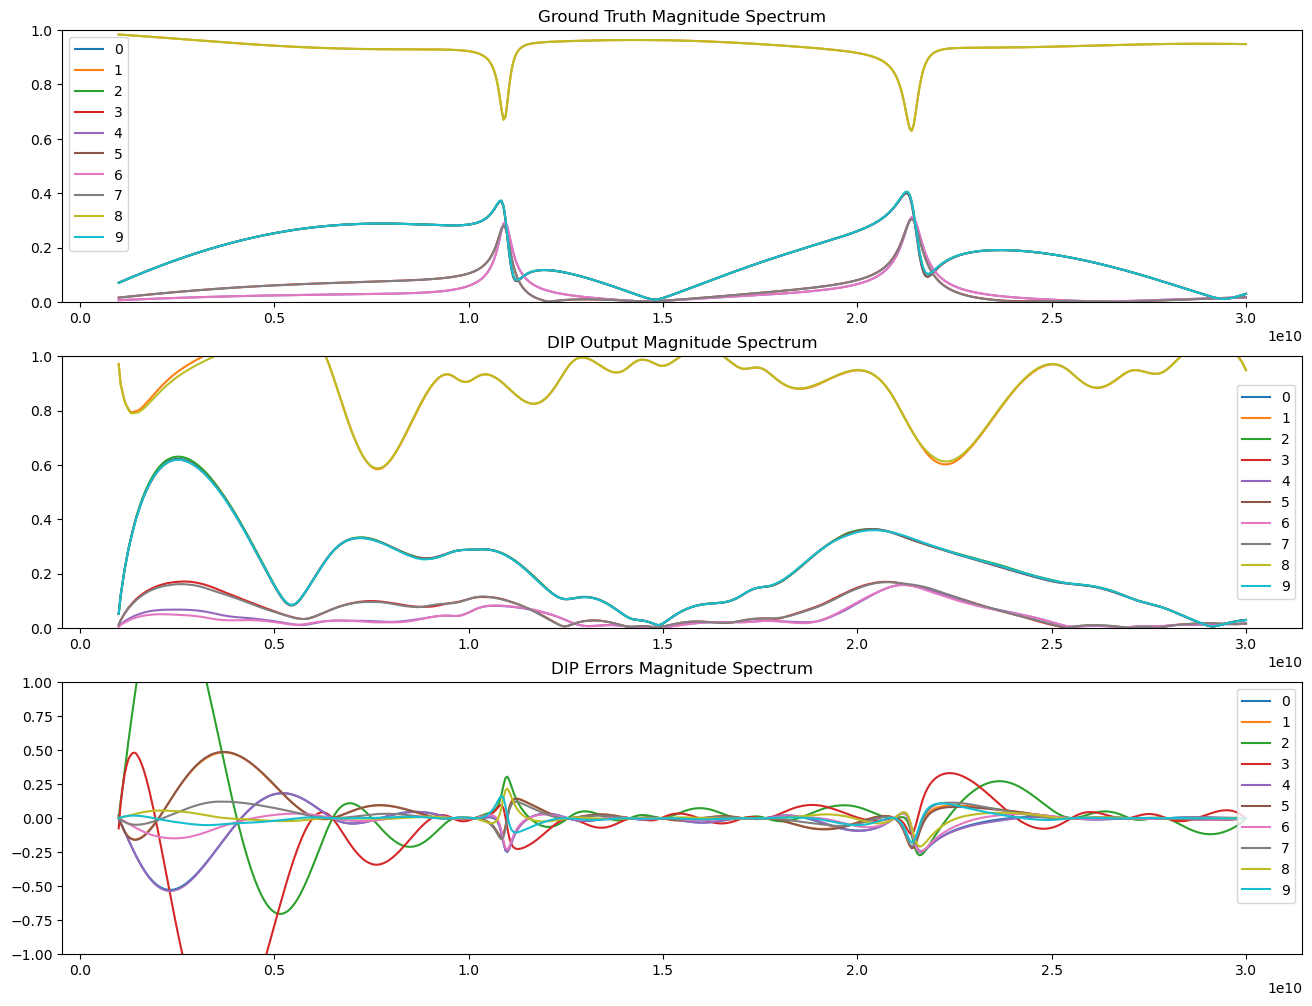

In [128]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [129]:
print(kept_inds)

[  0 110 172 183 231 263 279 321 333 399 490 520 539 580]
